# THIES Binary Processor

THIES DL16 exports two types of data in two different directories: 
* `ARCH_AV1` for avarage values of a 10 min span. Consists of 19 parameters of DataType Float.
* `ARCH_EX1` for both min and max values measured within the 10 min span. Consists of 32 parameters of DataType FloatExtrem.

There is a file for each day measured. File names are in `YYYYMMDD.BIN` format. Additionally, in the same directory there should be a file called `DESCFILE.INI`.


### THIESData: Read .BIN files -> Export as .CSV

In [1]:
from thiesBP import THIESData, THIESDayData

folder = './BINFILES/ARCH_AV1' # These are AV files (EPII)

# Initialize THIESData object with datatype ('av' or 'ex') and folder path
data = THIESData('av', folder)

**Method 1**: Fast Read+Write Method
* `.read_write(outpath: str)`: Takes filename (outpath) as input. Reads the path given and writes all BIN file data in same CSV. Does NOT save the data in a Pandas DataFrame.

In [2]:
data.read_write(outpath='output_filename1')

Data written in: data_uncompleted.csv


**Method 2**: Load into DF and then write CSV
* `.load_df()`: Reads folder of .BIN files and transforms them into a Pandas DataFrame saved in the `.fullData` attribute.
* `df2csv(outpath)`: Takes filename (outpath) as input. Writes into CSV file the contents of the DataFrame.

In [3]:
# 1 --- LOAD DATAFRAME ---
# Read all files and make DF
data.load_df()
print(data.shape)

# 1 --- (Optional) FILL MISSING TIMESTAMPS ---
# Completes times with Null (144 measurements per day, one every 10min)
# data.load_df(complete_rows=True)
# print(data.shape)

# 2 --- (Optional) FILL MISSING TIMESTAMPS ---
# Completes missing days with Null
# data.complete_empty_dates()
# print(data.shape)

# 3 --- WRITE DATA ---
# Write DF into CSV file
data.df2csv(outpath='output_filename2')

(16027, 21)


With this method we can access the data directly from this notebook.

In [4]:
data.fullData

,Date,Time,UBat,Pressure,PrTemp,Precipitation,WS,WD,WS std. dev.,WD std. dev.,...,AirTemperature,Radiation,PicoMoisture 1,PicoSoilTemp 1,PicoMoisture 2,PicoSoilTemp 2,CO2,UVA Radiation,UVB Radiation,PAR Radiation
0,2024/05/28,00:00,11.8,1011.4,5.4,0,0.8,66.5,0.2,45.9,...,2.5,0.5,None,None,None,None,515.9,-0.1,0,-0.8
1,2024/05/28,00:10,11.8,1011.2,5.4,0,0.4,41.2,0.2,48.3,...,2.4,0.4,None,None,None,None,524.7,-0.1,0,-0.8
2,2024/05/28,00:20,11.8,1011.0,5.4,0,0.6,52.7,0.2,17.9,...,2.5,0.4,None,None,None,None,531.0,-0.1,0,-0.8
3,2024/05/28,00:30,11.8,1010.9,5.4,0,0.6,93.1,0.2,50.8,...,2.6,0.4,None,None,None,None,522.2,-0.1,0,-0.8
4,2024/05/28,00:40,11.8,1010.8,5.4,0,0.6,26.7,0.1,37.2,...,2.6,0.5,None,None,None,None,527.0,-0.1,0,-0.8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16022,2024/09/30,13:20,14.5,1012.5,13.0,0,2.9,244.9,1.1,33.6,...,8.6,607.0,None,None,None,None,425.4,18.3,0.2,476.7
16023,2024/09/30,13:30,14.5,1012.5,13.9,0,2.6,234.0,1.2,40.2,...,8.6,556.2,None,None,None,None,425.6,17.7,0.2,443.6
16024,2024/09/30,13:40,14.5,1012.5,13.8,0,2.9,238.6,0.9,27.4,...,8.6,606.4,None,None,None,None,426.1,18.7,0.2,481.1
16025,2024/09/30,13:50,14.8,1012.6,13.3,0,3.2,239.7,1.0,30.9,...,8.9,594.1,None,None,None,None,426.6,18.6,0.2,473.0


In [5]:
print(f'Shape of the DataFrame: {data.shape}')
print(f'Number of files read: {data.size}')

Shape of the DataFrame: (16027, 21)
Number of files read: 114


### THIESDayData
This class is made to handle a single .BIN file that represents the data of a single day.

In [13]:
# Example paths of individual files (EPII)
path_bin_av = 'BINFILES/ARCH_AV1/20240530.BIN'
path_bin_ex = 'BINFILES/ARCH_EX1/20240530.BIN'
path_ini_av = 'BINFILES/ARCH_AV1/DESCFILE.INI'
path_ini_ex = 'BINFILES/ARCH_EX1/DESCFILE.INI'


#### Example 1: AV files

In [14]:
from thiesBP import THIESData, THIESDayData
data1 = THIESDayData('av')
data1.read_binfile(path_bin_av, path_ini_av)
data1.info
data1


=== THIES Day Data Instance ===

Bytes per row (BPR): 99
Bytes per parameter (BPP): 5
Datatype: av
Binfile: b'\x00\x00|a\x00C\x08;'...
Descfile: {1: {'name': 'UBat', 'classid': 24, 'objectid': 874, 'offset': 0, 'size': 5, 'linkid': 213, 'unitid': 17, 'typeid': 14, 'avtype': 0}, 2: {'name': 'Pressure', 'classid': 24, 'objectid': 687, 'offset': 5, 'size': 5, 'linkid': 199, 'unitid': 5, 'typeid': 6, 'avtype': 0}, 3: {'name': 'PrTemp', 'classid': 24, 'objectid': 872, 'offset': 10, 'size': 5, 'linkid': 203, 'unitid': 3, 'typeid': 3, 'avtype': 0}, 4: {'name': 'Precipitation', 'classid': 24, 'objectid': 887, 'offset': 15, 'size': 5, 'linkid': 0, 'unitid': 9, 'typeid': 11, 'avtype': 0}, 5: {'name': 'WS', 'classid': 24, 'objectid': 1048, 'offset': 20, 'size': 5, 'linkid': 1550, 'pairref': 6, 'unitid': 1, 'typeid': 1, 'avtype': 0}, 6: {'name': 'WD', 'classid': 24, 'objectid': 229, 'offset': 25, 'size': 5, 'linkid': 1550, 'pairref': 5, 'unitid': 2, 'typeid': 2, 'avtype': 1}, 7: {'name': 'WS std. 

,Date,Time,UBat,Pressure,PrTemp,Precipitation,WS,WD,WS std. dev.,WD std. dev.,...,AirTemperature,Radiation,PicoMoisture 1,PicoSoilTemp 1,PicoMoisture 2,PicoSoilTemp 2,CO2,UVA Radiation,UVB Radiation,PAR Radiation
0,2024/05/30,00:00,11.7,1018.1,6.5,0,0.8,51.5,0.1,20.8,...,3.5,-0.3,None,None,None,None,472.3,-0.1,0,-0.8
1,2024/05/30,00:10,11.7,1018.3,6.5,0,0.8,45.5,0.2,16.3,...,3.6,-0.2,None,None,None,None,471.7,-0.1,0,-0.8
2,2024/05/30,00:20,11.7,1018.5,6.4,0,0.9,56.2,0.2,28.5,...,3.7,-0.2,None,None,None,None,470.5,-0.1,0,-0.8
3,2024/05/30,00:30,11.7,1018.5,6.4,0,0.8,60.2,0.3,21.5,...,3.8,-0.1,None,None,None,None,472.6,-0.1,0,-0.8
4,2024/05/30,00:40,11.7,1018.6,6.4,0,0.8,52.1,0.3,23.4,...,3.8,-0.2,None,None,None,None,474.4,-0.1,0,-0.8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
139,2024/05/30,23:10,11.7,1014.1,8.2,0,0.1,41.8,0.2,31.6,...,5.0,-0.1,None,None,None,None,519.1,-0.1,0,-0.7
140,2024/05/30,23:20,11.7,1013.9,8.2,0,0.8,51.3,0.3,25.8,...,5.0,-0.1,None,None,None,None,520.5,-0.1,0,-0.7
141,2024/05/30,23:30,11.7,1013.9,8.1,0,0.4,60.4,0.3,47.6,...,5.1,-0.1,None,None,None,None,518.1,-0.1,0,-0.7
142,2024/05/30,23:40,11.7,1013.7,8.1,0,0.9,37.3,0.2,22.4,...,5.0,-0.1,None,None,None,None,521.8,-0.1,0,-0.7


In [15]:
data2 = THIESDayData('ex')
data2.read_binfile(path_bin_ex, path_ini_ex)
data2.info
data2

=== THIES Day Data Instance ===

Bytes per row (BPR): 292
Bytes per parameter (BPP): 9
Datatype: ex
Binfile: b'\x00\x00|a\x00\xdb\xe1:'...
Descfile: {1: {'name': 'UBat MIN', 'classid': 33, 'objectid': 964, 'offset': 0, 'size': 9, 'linkid': 213, 'extremid': 1, 'unitid': 17, 'typeid': 14, 'avtype': 0}, 2: {'name': 'UBat MAX', 'classid': 33, 'objectid': 1020, 'offset': 9, 'size': 9, 'linkid': 213, 'extremid': 2, 'unitid': 17, 'typeid': 14, 'avtype': 0}, 3: {'name': 'Pressure MIN', 'classid': 33, 'objectid': 625, 'offset': 18, 'size': 9, 'linkid': 199, 'extremid': 1, 'unitid': 5, 'typeid': 6, 'avtype': 0}, 4: {'name': 'Pressure MAX', 'classid': 33, 'objectid': 448, 'offset': 27, 'size': 9, 'linkid': 199, 'extremid': 2, 'unitid': 5, 'typeid': 6, 'avtype': 0}, 5: {'name': 'PrTemp MIN', 'classid': 33, 'objectid': 672, 'offset': 36, 'size': 9, 'linkid': 203, 'extremid': 1, 'unitid': 3, 'typeid': 3, 'avtype': 0}, 6: {'name': 'PrTemp MAX', 'classid': 33, 'objectid': 828, 'offset': 45, 'size': 9,

,Date,Time,UBat MIN,UBat MAX,Pressure MIN,Pressure MAX,PrTemp MIN,PrTemp MAX,WS MIN,WS MAX gust,...,PicoSoilTemp 2 MIN,PicoSoilTemp 2 MAX,CO2 MIN,CO2 MAX,UVA Radiation MIN,UVA Radiation MAX,UVB Radiation MIN,UVB Radiation MAX,PAR Radiation MIN,PAR Radiation MAX
0,2024/05/30,00:00,11.7,11.7,1018.0,1018.3,6.5,6.6,0.5,1.2,...,None,None,464.4,479.5,-0.1,-0.1,0,0,-0.8,-0.7
1,2024/05/30,00:10,11.7,11.7,1018.1,1018.5,6.4,6.5,0.5,1.3,...,None,None,466.3,477.4,-0.1,-0.1,0,0,-0.8,-0.7
2,2024/05/30,00:20,11.7,11.7,1018.3,1018.6,6.4,6.5,0.4,1.5,...,None,None,465.4,479.7,-0.1,-0.1,0,0,-0.8,-0.7
3,2024/05/30,00:30,11.7,11.7,1018.4,1018.7,6.4,6.5,0.4,1.5,...,None,None,463.8,485.2,-0.1,-0.1,0,0,-0.8,-0.7
4,2024/05/30,00:40,11.7,11.7,1018.4,1018.8,6.4,6.5,0.3,1.6,...,None,None,468.2,481.4,-0.1,-0.1,0,0,-0.8,-0.7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
139,2024/05/30,23:10,11.7,11.7,1013.9,1014.3,8.2,8.3,0.0,1.0,...,None,None,494.3,538.6,-0.1,-0.1,0,0,-0.8,-0.7
140,2024/05/30,23:20,11.7,11.7,1013.7,1014.0,8.1,8.2,0.0,1.3,...,None,None,509.5,533.2,-0.1,-0.1,0,0,-0.8,-0.7
141,2024/05/30,23:30,11.7,11.7,1013.7,1014.0,8.1,8.2,0.0,1.0,...,None,None,507.4,530.9,-0.1,-0.1,0,0,-0.8,-0.7
142,2024/05/30,23:40,11.7,11.7,1013.2,1013.9,8.1,8.1,0.5,1.3,...,None,None,516.8,528.1,-0.1,-0.1,0,0,-0.8,-0.7


EX files come with a timestamp for each measurement. These are saved separately in the `.datesDF` DataFrame.

In [16]:
# At what time was the MAX/MIN measurment taken (hh:mm)
data2.datesDF

,Date,Time,UBat MIN,UBat MAX,Pressure MIN,Pressure MAX,PrTemp MIN,PrTemp MAX,WS MIN,WS MAX gust,...,PicoSoilTemp 2 MIN,PicoSoilTemp 2 MAX,CO2 MIN,CO2 MAX,UVA Radiation MIN,UVA Radiation MAX,UVB Radiation MIN,UVB Radiation MAX,PAR Radiation MIN,PAR Radiation MAX
0,2024/05/30,00:00,23:50,23:50,23:53,23:59,23:51,23:50,23:54,23:57,...,None,None,23:54,23:52,23:54,23:57,23:53,23:57,23:53,23:57
1,2024/05/30,00:10,00:00,00:00,00:01,00:09,00:04,00:00,00:05,00:09,...,None,None,00:06,00:03,00:02,00:08,00:01,00:09,00:02,00:04
2,2024/05/30,00:20,00:10,00:11,00:14,00:18,00:10,00:10,00:18,00:13,...,None,None,00:13,00:17,00:11,00:15,00:14,00:17,00:14,00:17
3,2024/05/30,00:30,00:20,00:20,00:20,00:26,00:20,00:24,00:27,00:29,...,None,None,00:23,00:29,00:23,00:28,00:23,00:28,00:25,00:29
4,2024/05/30,00:40,00:30,00:31,00:31,00:38,00:30,00:30,00:36,00:31,...,None,None,00:35,00:33,00:36,00:33,00:35,00:36,00:37,00:36
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
139,2024/05/30,23:10,23:00,23:00,23:09,23:04,23:00,23:00,23:09,23:10,...,None,None,23:00,23:05,23:00,23:08,23:00,23:06,23:00,23:04
140,2024/05/30,23:20,23:10,23:10,23:18,23:10,23:17,23:10,23:19,23:15,...,None,None,23:18,23:11,23:17,23:16,23:18,23:13,23:18,23:12
141,2024/05/30,23:30,23:20,23:20,23:20,23:25,23:20,23:20,23:26,23:30,...,None,None,23:22,23:27,23:24,23:28,23:23,23:27,23:25,23:21
142,2024/05/30,23:40,23:30,23:30,23:38,23:30,23:30,23:30,23:36,23:39,...,None,None,23:39,23:33,23:36,23:33,23:30,23:32,23:30,23:32


# Visualizations

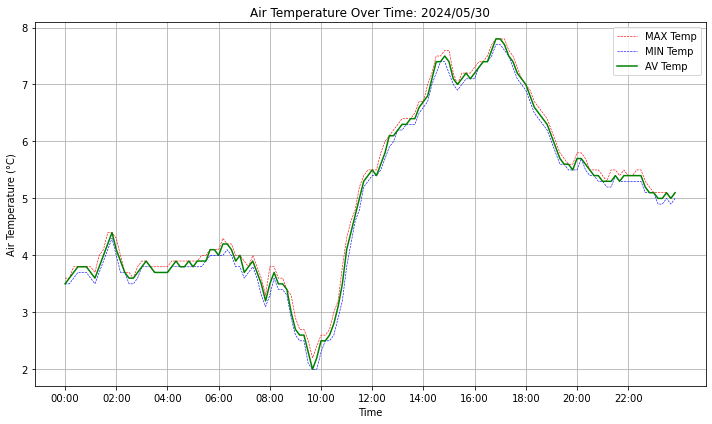

In [17]:
import matplotlib.pyplot as plt
        
df = data1.dataDF
df2 = data2.dataDF

idx = df2['Time']

plt.figure(figsize=(10, 6))
plt.plot(idx, df2['AirTemperature MAX'], linestyle='--', color='r', label='MAX Temp', lw=0.6)
plt.plot(idx, df2['AirTemperature MIN'], linestyle='--', color='b', label='MIN Temp', lw=0.6)
plt.plot(idx, df['AirTemperature'], linestyle='-', color='g', label='AV Temp')
plt.title(f'Air Temperature Over Time: {data1.date}')
plt.xlabel('Time')
plt.ylabel('Air Temperature (°C)')

num_dates_to_show = 12
plt.xticks(idx[::len(df)//num_dates_to_show], rotation=0)  # Show every n-th date

plt.grid()
plt.legend()
plt.tight_layout()
plt.show()